In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/commit_test_folder/EECE491-01-Capstone-Design')

Mounted at /content/drive


In [6]:
# -------------------------------------------------
# 2. AN-based PLS Channel Definitions
# (PLS 채널 시뮬레이션을 위한 모든 헬퍼 함수)
# -------------------------------------------------

def cn01(shape):
    a = np.random.randn(*shape).astype(np.float32)
    b = np.random.randn(*shape).astype(np.float32)
    return (a + 1j * b).astype(np.complex64) / np.sqrt(2.0).astype(np.float32)

def normalize(v, eps=1e-12):
    n = np.linalg.norm(v)
    return v if n < eps else v / n

def sample_channels(Nt, Ne):
    hb = cn01((Nt, 1))      # Bob 채널
    He = cn01((Nt, Ne))     # Eve 채널
    return hb, He

def precoder_mrt(hb_hat):
    return normalize(hb_hat.astype(np.complex64)).astype(np.complex64)

def projector_null(hb_hat):
    w = normalize(hb_hat.astype(np.complex64))
    return np.eye(len(hb_hat), dtype=np.complex64) - (w @ w.conj().T)

def pls_an_channel(s, alpha, hb, He,
                   Ptot=1.0, SNRdB=10.0,
                   imperfect_csi=False, csi_err_var=0.0):
    """
    단일 스트림 AN 기반 PLS 채널 (Bob과 Eve의 수신 심볼 반환)
    s : (Nsym,) complex64
    """
    Nt, Ne = He.shape[0], He.shape[1]
    sigma2 = np.float32(Ptot * 10**(-SNRdB / 10))

    if imperfect_csi:
        e = cn01((Nt, 1)) * np.sqrt(np.float32(csi_err_var))
        hb_hat = (hb + e).astype(np.complex64)
    else:
        hb_hat = hb.astype(np.complex64)

    w = precoder_mrt(hb_hat)      # (Nt,1)
    Pnull = projector_null(hb_hat) # (Nt,Nt)

    Ps  = np.float32((1.0 - alpha) * Ptot)
    Pan = np.float32(alpha * Ptot)
    Nsym = s.shape[0]

    z = cn01((Nt, Nsym))
    n_mat = Pnull @ z
    n_mat = n_mat / (np.linalg.norm(n_mat, axis=0, keepdims=True) + 1e-12)

    x = (np.sqrt(Ps).astype(np.float32) * (w @ s.reshape(1, -1))).T \
        + np.sqrt(Pan).astype(np.float32) * n_mat.T

    # --- Bob 수신 ---
    nb = (np.sqrt(sigma2 / 2.0) * cn01((Nsym, 1))).flatten()
    yb = (hb.conj().T @ x.T).flatten() + nb  # (Nsym,)

    # --- Eve 수신 ---
    ne = (np.sqrt(sigma2 / 2.0) * cn01((Nsym, Ne)))
    Ye = (He.conj().T @ x.T).T + ne      # (Nsym, Ne)
    y_e = Ye.sum(axis=1)                 # (Eve가 여러 안테나의 신호를 합침)

    return yb.astype(np.complex64), y_e.astype(np.complex64)

def latent_to_complex_np(latent_torch: torch.Tensor):
    """ [B, D] real 텐서를 [B, D/2] complex numpy 배열로 변환 """
    z = latent_torch.detach().cpu().numpy().astype(np.float32)
    B, D = z.shape
    assert D % 2 == 0, "latent_dim must be even to map to complex symbols"
    real = z[:, 0::2]
    imag = z[:, 1::2]
    s = (real + 1j * imag).astype(np.complex64)
    return s

def complex_to_latent_torch(s_np: np.ndarray, device):
    """ [B, Nsym] complex numpy 배열을 [B, 2*Nsym] real 텐서로 변환 """
    real = np.real(s_np).astype(np.float32)
    imag = np.imag(s_np).astype(np.float32)
    z = np.stack([real, imag], axis=-1).reshape(real.shape[0], -1)
    z_torch = torch.from_numpy(z).to(device)
    return z_torch

def an_pls_channel(latent_vector: torch.Tensor,
                   snr_db: float,
                   alpha: float = 0.5,
                   Nt: int = 4,
                   Ne: int = 1,
                   Ptot: float = 1.0,
                   imperfect_csi: bool = False,
                   csi_err_var: float = 0.0):
    """
    AWGN 채널을 대체하는 메인 PLS 채널 함수.
    (Bob과 Eve의 latent 텐서를 모두 반환)
    """
    device = latent_vector.device
    B, D = latent_vector.shape

    s_batch = latent_to_complex_np(latent_vector)
    B, Nsym = s_batch.shape

    yb_list = []
    ye_list = []

    for b in range(B):
        hb, He = sample_channels(Nt, Ne)

        yb, y_e = pls_an_channel(
            s_batch[b],
            alpha=alpha,
            hb=hb,
            He=He,
            Ptot=Ptot,
            SNRdB=snr_db,
            imperfect_csi=imperfect_csi,
            csi_err_var=csi_err_var
        )
        yb_list.append(yb)
        ye_list.append(y_e)

    yb_arr = np.stack(yb_list, axis=0) # [B, Nsym]
    ye_arr = np.stack(ye_list, axis=0) # [B, Nsym]

    latent_bob = complex_to_latent_torch(yb_arr, device=device)
    latent_eve = complex_to_latent_torch(ye_arr, device=device)

    return latent_bob, latent_eve

In [3]:
# This cell prepares the Colab environment by copying and
# extracting the dataset from Google Drive to the fast local SSD.

import os
import time

# --- Part 1: Colab Local Data Setup ---
print("Starting data setup...")
start_setup_time = time.time()

# --- Define paths ---
DRIVE_ARCHIVE_PATH = "/content/drive/MyDrive/datasets/cropped_celeba.tar"
LOCAL_ARCHIVE_PATH = "/content/cropped_celeba.tar"
EXTRACT_PATH = "/content/celeba_dataset"

# The final, correct path to the images, based on our investigation
LOCAL_DATA_DIR = os.path.join(EXTRACT_PATH, "content", "cropped_celeba")

# --- Logic ---
# Only copy/untar if the local data directory doesn't already exist
if not os.path.exists(LOCAL_DATA_DIR):
    print(f"Copying {DRIVE_ARCHIVE_PATH} to local runtime...")
    if not os.path.exists(DRIVE_ARCHIVE_PATH):
        print(f"[FATAL ERROR] Source file not found: {DRIVE_ARCHIVE_PATH}")
        raise FileNotFoundError(f"Source file not found: {DRIVE_ARCHIVE_PATH}")

    # 1. Copy the single .tar file from Drive (fast)
    !cp "{DRIVE_ARCHIVE_PATH}" "{LOCAL_ARCHIVE_PATH}"
    print("Copy complete.")

    # 2. Extract the archive to the local SSD (fast)
    print(f"Untarring {LOCAL_ARCHIVE_PATH} to {EXTRACT_PATH}...")
    !mkdir -p "{EXTRACT_PATH}"
    !tar -xf "{LOCAL_ARCHIVE_PATH}" -C "{EXTRACT_PATH}"
    print("Untar complete.")

    # 3. Clean up the local archive to save space
    !rm "{LOCAL_ARCHIVE_PATH}"
else:
    print(f"Data directory {LOCAL_DATA_DIR} already exists. Skipping copy/untar.")

print(f"Data setup finished in {time.time() - start_setup_time:.2f} seconds.")

# --- Sanity Check ---
# Crucial check to ensure data exists before proceeding
if not os.path.exists(LOCAL_DATA_DIR):
    print(f"\n[FATAL ERROR] The expected data directory does not exist: {LOCAL_DATA_DIR}")
    raise FileNotFoundError(f"Could not find data at {LOCAL_DATA_DIR}")
else:
    print(f"Successfully found data at: {LOCAL_DATA_DIR}")

Starting data setup...
Copying /content/drive/MyDrive/datasets/cropped_celeba.tar to local runtime...
Copy complete.
Untarring /content/cropped_celeba.tar to /content/celeba_dataset...
Untar complete.
Data setup finished in 27.57 seconds.
Successfully found data at: /content/celeba_dataset/content/cropped_celeba


In [4]:
import torch
# Import the function from the data_utils.py file we created
from src.utils.data_utils import get_dataloaders

# --- Configuration ---
# Use the local data path defined in Cell 1
DATA_ROOT = LOCAL_DATA_DIR
BATCH_SIZE = 256
IMAGE_SIZE = 128
RANDOM_SEED = 42

# --- 1. Get Dataloaders ---
# This single function call does all the work
train_loader, val_loader, test_loader = get_dataloaders(
    root_dir=DATA_ROOT,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    random_seed=RANDOM_SEED
)

# --- 2. Verification ---
# Final check to ensure the dataloader works
if train_loader:
    print("\nVerifying one batch from train_loader...")
    try:
        # Get one sample batch
        images, labels = next(iter(train_loader))
        print(f"  Batch loaded successfully.")
        print(f"  Image batch shape: {images.shape}")
        print("\nSetup complete. You are ready to start training.")
    except Exception as e:
        print(f"  [Error] Failed to load batch: {e}")
else:
    print("\nData loading failed. Please check previous cell output.")


Loading dataset from: /content/celeba_dataset/content/cropped_celeba
Searching for '*.jpg' files in: /content/celeba_dataset/content/cropped_celeba
Successfully found 199509 images.
Successfully loaded 199509 total images.
Splitting dataset into:
  Train: 159607 images
  Validation: 19950 images
  Test: 19952 images

DataLoaders created successfully.

Verifying one batch from train_loader...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Batch loaded successfully.
  Image batch shape: torch.Size([256, 3, 128, 128])

Setup complete. You are ready to start training.


Selected validation indices: [2535, 18654, 10654, 9464]
Successfully loaded 4 specific images from VAL_DATASET.

--- Processing Model: face_autoencoder_512.pth ---
Model loaded successfully.

--- Processing Model: face_autoencoder_512_SSIM.pth ---
Model loaded successfully.


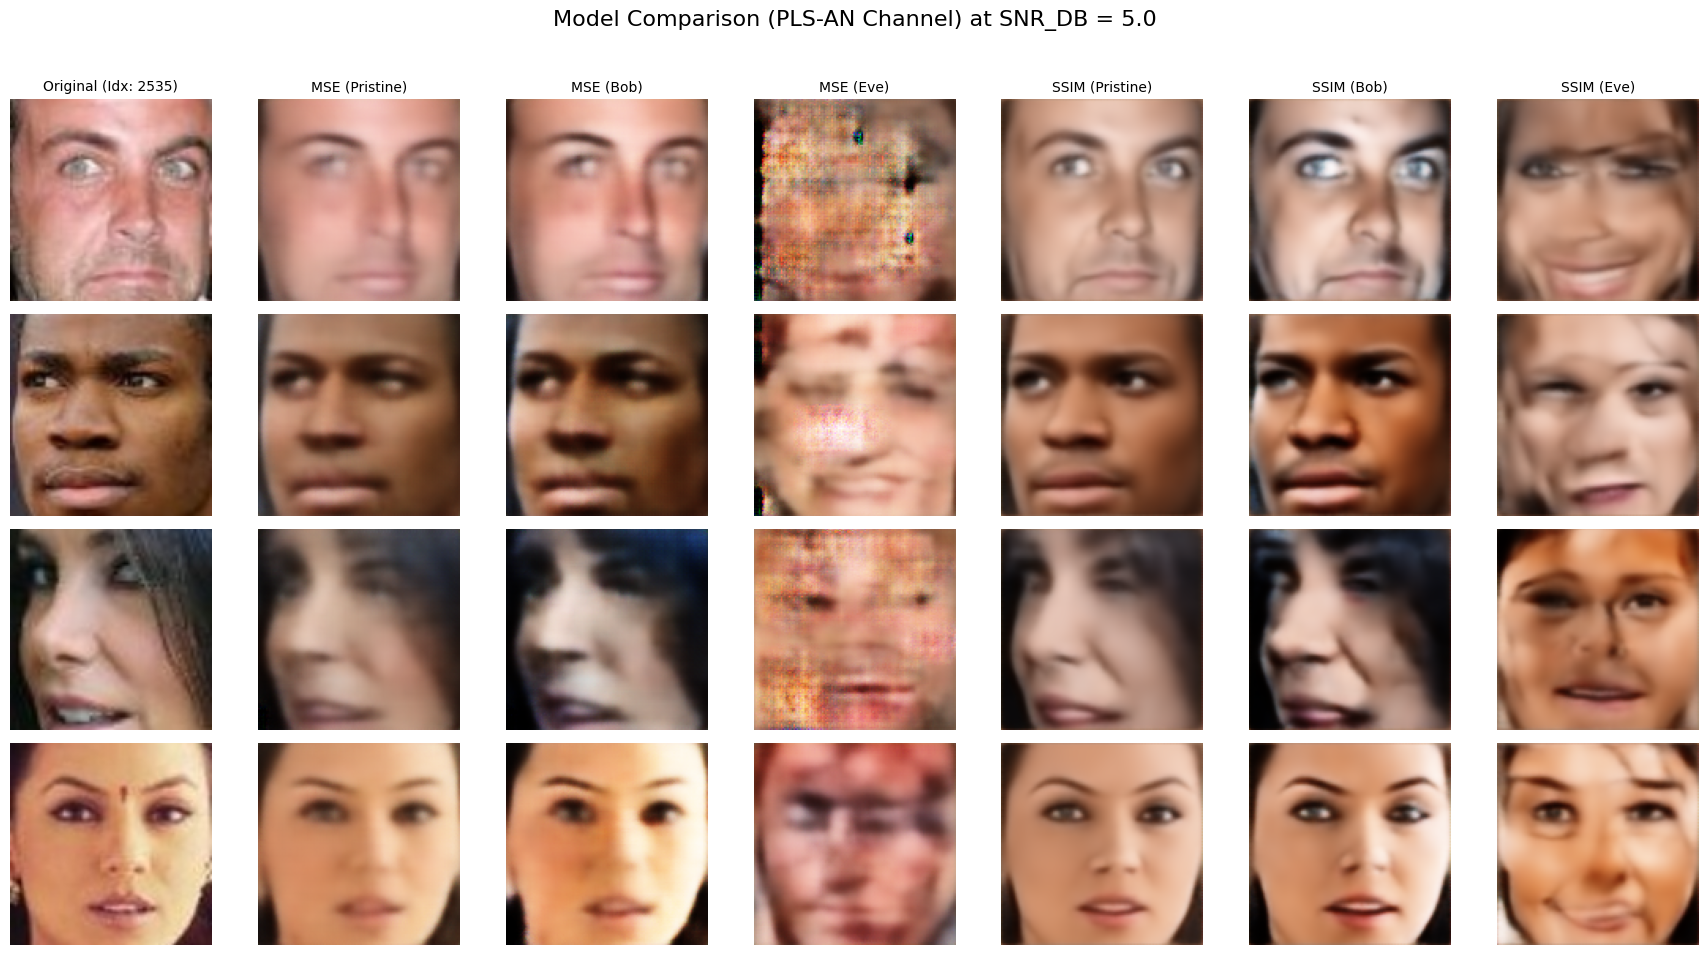

In [7]:
import torch
import torch.nn as nn
import numpy as np # 👈 PLS 헬퍼 함수에 필요
import os
import random
import matplotlib.pyplot as plt

# --- 1. Module Imports ---
# (src 폴더 경로는 셀 1에서 이미 설정됨)
from src.utils.viz_utils import render_tensor
from src.models.face_autoencoder import FaceAutoencoder


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "/content/drive/MyDrive/models"
VISUALIZE_SNR_DB = 5.0 # PLS 채널의 SNRdB로 사용됨
NUM_IMAGES_TO_SHOW = 4

# --- 비교할 모델 목록 ---
MODEL_CONFIGS = [
    (512, "_512.pth", "MSE"),
    (512, "_512_SSIM.pth", "SSIM")
]

try:
    val_subset = val_loader.dataset
    full_dataset = val_subset.dataset
    validation_indices = val_subset.indices

    max_index = len(validation_indices) - 1

    # (고정된 샘플을 보고 싶으면 이 리스트를 수정하세요)
    # IMAGE_INDICES_TO_SHOW_LIST = [100, 150, 200, 250]

    # (무작위 샘플을 보려면 이 코드를 사용하세요)
    IMAGE_INDICES_TO_SHOW_LIST = random.sample(range(max_index), k=NUM_IMAGES_TO_SHOW)

    print(f"Selected validation indices: {IMAGE_INDICES_TO_SHOW_LIST}")

    image_list = []
    for idx in IMAGE_INDICES_TO_SHOW_LIST:
        original_idx = validation_indices[idx]
        image_tensor = full_dataset[original_idx][0]
        image_list.append(image_tensor)

    sample_images = torch.stack(image_list).to(device)
    print(f"Successfully loaded {len(sample_images)} specific images from VAL_DATASET.")

except NameError:
    print("[ERROR] val_loader is not defined. Please run the Dataloader setup cell first.")
    # exit() # Colab에서는 exit() 대신 pass 또는 raise를 사용합니다.
except Exception as e:
    print(f"An error occurred: {e}")


# -----------------------------------------------
# 5. Main Plotting Loop (Bob, Eve 모두 처리)
# -----------------------------------------------
reconstruction_results = {}

for latent_dim, suffix, display_name in MODEL_CONFIGS:
    model_name = f"face_autoencoder{suffix}"
    MODEL_PATH = os.path.join(SAVE_DIR, model_name)
    print(f"\n--- Processing Model: {model_name} ---")

    model = FaceAutoencoder(latent_dim=latent_dim).to(device)
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.eval()
        print("Model loaded successfully.")
    except FileNotFoundError:
        print(f"[ERROR] Model file not found at {MODEL_PATH}. Skipping.")
        reconstruction_results[display_name] = {'pristine': None, 'bob': None, 'eve': None}
        continue

    with torch.no_grad():
        latent_original = model.encode(sample_images)

        # Bob과 Eve의 latent 텐서를 모두 받음
        latent_bob, latent_eve = an_pls_channel(
            latent_original,
            snr_db=VISUALIZE_SNR_DB
            # (alpha=0.5, Nt=4, Ne=1 등 기본값 사용)
        )

        # 4개의 복원 이미지 생성
        recon_pristine = model.decode(latent_original) # 1. 원본 (노이즈 X)
        recon_bob = model.decode(latent_bob)           # 2. Bob (보안 채널)
        recon_eve = model.decode(latent_eve)           # 3. Eve (도청 채널)

        reconstruction_results[display_name] = {
            'pristine': recon_pristine,
            'bob': recon_bob,
            'eve': recon_eve
        }

# -----------------------------------------------
# 6. Plotting (Bob, Eve 모두 표시)
# -----------------------------------------------
num_cols_per_image = 1 + len(MODEL_CONFIGS) * 3
num_rows = NUM_IMAGES_TO_SHOW

fig, axes = plt.subplots(num_rows, num_cols_per_image, figsize=(num_cols_per_image * 2.5, num_rows * 2.5))
fig.suptitle(f"Model Comparison (PLS-AN Channel) at SNR_DB = {VISUALIZE_SNR_DB}", fontsize=16)

# --- 각 열의 헤더(제목) 정의 ---
column_titles = ["Original"]
for _, _, display_name in MODEL_CONFIGS:
    column_titles.append(f"{display_name} (Pristine)")
    column_titles.append(f"{display_name} (Bob)")
    column_titles.append(f"{display_name} (Eve)")

for row_idx in range(NUM_IMAGES_TO_SHOW):
    # (인덱스 번호 표시)
    current_val_index = IMAGE_INDICES_TO_SHOW_LIST[row_idx]
    original_title = f"Original (Idx: {current_val_index})"
    title_to_show = original_title if row_idx == 0 else None
    if row_idx > 0:
        axes[row_idx, 0].set_ylabel(f"Val Idx: {current_val_index}", fontsize=10, labelpad=20)

    render_tensor(axes[row_idx, 0], sample_images[row_idx],
           title=title_to_show)

    col_offset = 1
    for _, _, display_name in MODEL_CONFIGS:
        recons = reconstruction_results.get(display_name, {'pristine': None, 'bob': None, 'eve': None})

        # 1. Pristine 복원
        if recons['pristine'] is not None:
            render_tensor(axes[row_idx, col_offset], recons['pristine'][row_idx],
                   title=column_titles[col_offset] if row_idx == 0 else None)
        else:
            axes[row_idx, col_offset].set_title("N/A", fontsize=10) if row_idx == 0 else None
            axes[row_idx, col_offset].axis('off')
        col_offset += 1

        # 2. Bob 복원
        if recons['bob'] is not None:
            render_tensor(axes[row_idx, col_offset], recons['bob'][row_idx],
                   title=column_titles[col_offset] if row_idx == 0 else None)
        else:
            axes[row_idx, col_offset].set_title("N/A", fontsize=10) if row_idx == 0 else None
            axes[row_idx, col_offset].axis('off')
        col_offset += 1

        # 3. Eve 복원
        if recons['eve'] is not None:
            render_tensor(axes[row_idx, col_offset], recons['eve'][row_idx],
                   title=column_titles[col_offset] if row_idx == 0 else None)
        else:
            axes[row_idx, col_offset].set_title("N/A", fontsize=10) if row_idx == 0 else None
            axes[row_idx, col_offset].axis('off')
        col_offset += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()